In [1]:
import pandas as pd
import numpy as np
import re
import os
import random
import subprocess
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from Bio import SeqIO
from tqdm import tqdm
%matplotlib inline

In [2]:
PATH = "/home/mchernigovskaya/data/paired/10x"

In [3]:
# help functions

def dict_to_sorted_df_with_perc(dict_name, column_name):
    df = dict_to_sorted_df(dict_name, ['# ' + column_name])
    df = add_perc_to_df(df, column_name)
    return df

def dict_to_sorted_df(dict_name, column_labels):
    df = pd.DataFrame.from_dict(dict_name, orient='index')
    df.columns = column_labels
    return df.sort_index(0)

def add_perc_to_df(dict_name, column_name):
    dict_name['% ' + column_name] = dict_name['# '+column_name] / sum(dict_name['# '+column_name]) * 100
    return dict_name

def get_counter_dict(v):
    return dict(Counter(v))

# 0. Filter contigs by number of UMIs

Filter out contigs with #UMIs <= N_UMIS 

In [4]:
N_UMIS = 5

In [5]:
dataset_name = 'cd19'

annotation_fname = PATH + '/{}/vdj_v1_{}_b_filtered_contig_annotations.csv'.format(dataset_name, dataset_name)
contigs_fname = PATH + '/{}/vdj_v1_{}_b_filtered_contig.fasta'.format(dataset_name, dataset_name)

filtered_annotation_fname = annotation_fname[:-4] + '_filtered_{}_UMIs.csv'.format(N_UMIS) 
filtered_contigs_fname = contigs_fname[:-6] + '_filtered_{}_UMIs.fasta'.format(N_UMIS) 

In [6]:
def filter_contigs_info_by_umis(annotation_fname, treshold=N_UMIS):
    contigs_info = pd.read_csv(annotation_fname, delimiter=',')
    return contigs_info.loc[contigs_info['umis'] > treshold]
    
    
def report_filtered_files(filtered_contigs_info, contigs_fname):
    filtered_contigs_info.to_csv(filtered_annotation_fname)
    print('\nFiltered annotation was written to {}\n'.format(filtered_annotation_fname))    
    
    filtered_contig_id = set(filtered_contigs_info['contig_id'])
    # overwrite the old data 
    open(filtered_contigs_fname, 'w').close()
    with open(filtered_contigs_fname, 'a') as f:
        for rec in SeqIO.parse(contigs_fname, "fasta"):
            if rec.id in filtered_contig_id: 
                SeqIO.write(rec, f, "fasta")
    print('\nFiltered contigs were written to {}\n'.format(filtered_contigs_fname))

    
def filter_contigs(annotation_fname, contigs_fname): 
    filtered_contigs_info = filter_contigs_info_by_umis(annotation_fname)
    report_filtered_files(filtered_contigs_info, contigs_fname)

In [7]:
filter_contigs(annotation_fname, contigs_fname)


Filtered annotation was written to /home/mchernigovskaya/data/paired/10x/cd19/vdj_v1_cd19_b_filtered_contig_annotations_filtered_5_UMIs.csv


Filtered contigs were written to /home/mchernigovskaya/data/paired/10x/cd19/vdj_v1_cd19_b_filtered_contig_filtered_5_UMIs.fasta



# 1. Process 10x annotation: Multi chains

Looking for trash in 10x annotation. I strongly believe that multi contigs are wrong. 

In [8]:
filtered_contigs_annotation = pd.read_csv(filtered_annotation_fname, index_col='contig_id')

In [9]:
filtered_contigs_annotation.head()

,Unnamed: 0,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
contig_id,,,,,,,,,,,,,,,,,,
AAACCTGAGACCACGA-1_contig_1,0,AAACCTGAGACCACGA-1,True,True,744,IGL,IGLV3-21,None,IGLJ2,IGLC2,True,True,CQVWDSNSDHVVF,TGTCAGGTGTGGGATAGTAATAGTGATCATGTGGTCTTC,3309,35,clonotype109,clonotype109_consensus_1
AAACCTGAGACCACGA-1_contig_2,1,AAACCTGAGACCACGA-1,True,True,587,IGH,IGHV1-2,IGHD1-1,IGHJ6,IGHD,True,True,CATGRTDHSDGMDVW,TGTGCGACTGGAAGGACCGACCACTCTGACGGTATGGACGTCTGG,5256,20,clonotype109,clonotype109_consensus_2
AAACCTGAGCGTAATA-1_contig_3,4,AAACCTGAGCGTAATA-1,True,True,625,IGH,IGHV3-33,IGHD3-10,IGHJ5,IGHM,True,True,CARDRGDTMVRGVSNWFDPW,TGTGCGAGAGATCGCGGGGATACTATGGTTCGGGGAGTTAGTAACT...,7191,30,clonotype110,clonotype110_consensus_2
AAACCTGAGCGTAATA-1_contig_5,6,AAACCTGAGCGTAATA-1,True,True,680,IGL,IGLV2-14,None,IGLJ1,IGLC1,True,True,CSSYTSSSTLYVF,TGCAGCTCATATACAAGCAGCAGCACCCTTTATGTCTTC,4089,33,clonotype110,clonotype110_consensus_1
AAACCTGAGGCATTGG-1_contig_1,7,AAACCTGAGGCATTGG-1,True,True,643,IGL,IGLV2-18,None,IGLJ1,IGLC1,True,True,CSSYTSSNTYVF,TGCAGCTCATATACAAGCAGCAACACTTATGTCTTC,9589,66,clonotype111,clonotype111_consensus_1


##  1.1. Multi chains are longer than common BCR contigs

Some contigs are too long (Multi and TRB)

Number of all chains: 22096


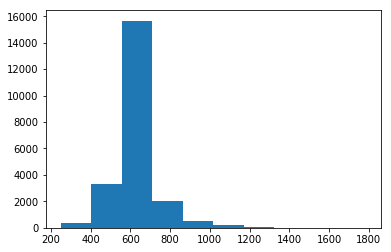

In [10]:
print("Number of all chains: {}".format(len(filtered_contigs_annotation)))
plt.hist(filtered_contigs_annotation['length'])  
plt.show()

In [11]:
def show_len_distr(chain):
    specific_chain = filtered_contigs_annotation.loc[filtered_contigs_annotation['chain'] == chain]
    print("Number of {} chains: {}".format(chain, len(specific_chain)))
    plt.hist(specific_chain['length'])
    plt.show()

Number of Multi chains: 1203


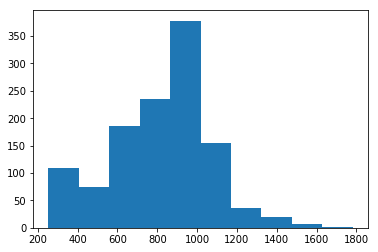

Number of TRB chains: 76


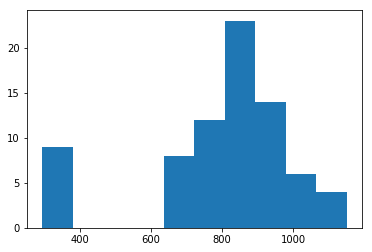

Number of IGH chains: 9327


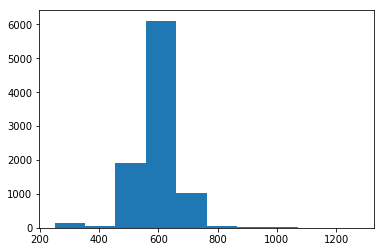

In [12]:
for chain in ['Multi', 'TRB', 'IGH']:
    show_len_distr(chain)

## 1.2. Multi chains have less UMIs than other contigs

Multi


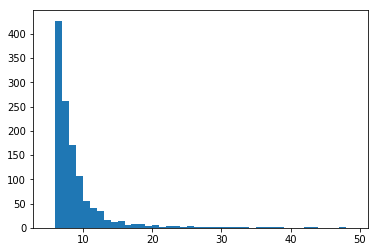

In [13]:
print("Multi")
multi_chains = filtered_contigs_annotation.loc[filtered_contigs_annotation['chain'] == 'Multi']
plt.hist(multi_chains['umis'], bins=range(N_UMIS, 50), range=(N_UMIS, 50))
plt.show()

Not multi


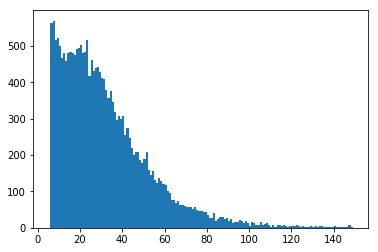

In [14]:
print("Not multi")
not_multi_chains = filtered_contigs_annotation.loc[filtered_contigs_annotation['chain'] != 'Multi']
plt.hist(not_multi_chains['umis'], bins=range(N_UMIS, 150), range=(N_UMIS, 150))
plt.show()

## 1.3. Multi chains: TCR gene + BCR gene

Some multi chains looks like (v_gene: TR., j_gene or c_gene: IG.)

In [15]:
multi_chains.head()

,Unnamed: 0,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
contig_id,,,,,,,,,,,,,,,,,,
AAACCTGTCGGTTCGG-1_contig_3,59,AAACCTGTCGGTTCGG-1,True,True,531,Multi,TRBV7-9,None,None,IGKC,False,None,None,None,2378,9,clonotype126,None
AAACCTGTCTGGCGAC-1_contig_14,63,AAACCTGTCTGGCGAC-1,True,True,675,Multi,TRBV11-1,None,TRAJ15,IGLC1,False,None,None,None,809,6,clonotype127,None
AAACGGGCAATGCCAT-1_contig_8,88,AAACGGGCAATGCCAT-1,True,True,884,Multi,TRBV6-7,None,None,IGHM,False,None,None,None,443,6,clonotype134,None
AAACGGGCACCAGATT-1_contig_3,91,AAACGGGCACCAGATT-1,True,True,910,Multi,IGLV3-32,None,None,IGHG2,False,None,None,None,2432,9,clonotype135,None
AAACGGGCAGTGACAG-1_contig_1,98,AAACGGGCAGTGACAG-1,True,True,1024,Multi,IGLV10-54,None,IGKJ1,IGKC,False,None,None,None,2689,13,clonotype137,None


In [16]:
def all_chains_are_from_one_cell_receptor(row):
    chain_types = [row['{}_gene'.format(gene_type)][0:2] for gene_type in ['v', 'd', 'j', 'c'] if row['{}_gene'.format(gene_type)] != 'None']
    return chain_types.count(chain_types[0]) != len(chain_types)

def get_tcr_bcr_chains(multi_chains):
    return multi_chains[multi_chains.apply(lambda row: all_chains_are_from_one_cell_receptor(row), axis=1)]

In [17]:
tcr_bcr_chains = get_tcr_bcr_chains(multi_chains)

In [18]:
print('Number of mixed contigs: {}\n'.format(len(tcr_bcr_chains)))
print('Their UMIs distribution (# UMIs : N contigs):')
print(Counter(tcr_bcr_chains['umis']))

Number of mixed contigs: 621

Their UMIs distribution (# UMIs : N contigs):
Counter({6: 233, 7: 131, 8: 81, 9: 55, 10: 29, 11: 21, 12: 19, 13: 10, 14: 8, 15: 7, 18: 4, 16: 2, 19: 2, 20: 2, 22: 2, 23: 2, 27: 2, 28: 2, 17: 1, 21: 1, 25: 1, 29: 1, 30: 1, 33: 1, 36: 1, 37: 1, 65: 1})


Examples of tcr_bcr chains with many UMIs:

In [19]:
tcr_bcr_chains.sort_values(by = 'umis', ascending=False).head()

,Unnamed: 0,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
contig_id,,,,,,,,,,,,,,,,,,
GAACATCTCGGCGGTT-1_contig_4,18264,GAACATCTCGGCGGTT-1,True,True,459,Multi,IGKV2D-28,None,TRAJ22,IGKC,False,None,None,None,20337,65,clonotype27,None
TCACAAGTCTTCATGT-1_contig_1,27813,TCACAAGTCTTCATGT-1,True,True,664,Multi,TRBV5-3,None,IGHJ4,IGHA1,False,None,None,None,9348,37,clonotype7757,None
ACTGATGTCAAGCCTA-1_contig_4,3654,ACTGATGTCAAGCCTA-1,True,True,925,Multi,IGKV1-8,None,TRAJ19,IGKC,False,None,None,None,7102,36,clonotype1104,None
CAGTCCTAGGAATGGA-1_contig_3,9785,CAGTCCTAGGAATGGA-1,True,True,441,Multi,IGLV2-14,None,TRAJ15,IGLC1,True,None,None,None,5543,33,clonotype2786,None
GACTACAGTAAGGATT-1_contig_3,19215,GACTACAGTAAGGATT-1,True,True,798,Multi,TRGV10,None,IGKJ3,IGKC,False,None,None,None,5195,30,clonotype5389,None


# 2. Process 10x annotation: other strange things

## 2.1. Pseudogenes ??

In [20]:
def get_pseudogenes(filtered_contigs_annotation):
    for gene_type in ['v', 'd', 'j', 'c']:
        genes = Counter(filtered_contigs_annotation['{}_gene'.format(gene_type)])
        for gene in genes:
            if gene[0:2] == "IG" and 'OR' in gene:
                print('{}: {}'.format(gene, genes[gene]))
        print("\n")

In [21]:
get_pseudogenes(filtered_contigs_annotation)

IGHV1OR21-1: 2
IGHV3OR16-12: 4
IGHV3OR16-10: 1
IGHV3OR16-9: 8
IGHV3OR16-8: 2
IGHV1OR15-1: 1
IGHV1OR15-9: 117
IGHV4OR15-8: 1


IGHD1OR15-1A: 61
IGHD5OR15-5B: 28
IGHD3OR15-3A: 44
IGHD4OR15-4B: 42
IGHD2OR15-2B: 69








## 2.2. .... 

# 3. VJfinder vs 10x annotaion 

From VJF log:

23.0826% of aligned reads have isotype IGL <br>
32.7312% of aligned reads have isotype IGK <br>
44.1862% of aligned reads have isotype IGH

20262 reads were aligned; 1834 reads were filtered out


In [22]:
vjf_annotation_fname = PATH + '/{}/vjf_result/alignment_info.csv'.format(dataset_name)

In [23]:
vjf_annotation = pd.read_csv(vjf_annotation_fname, sep='\t', index_col=0)

In [24]:
vjf_annotation.head()

,Chain_type,V_hit,V_start_pos,V_end_pos,V_score,J_hit,J_start_pos,J_end_pos,J_score
Read_name,,,,,,,,,
AAAGATGTCCGAATGT-1_contig_2,IGH,IGHV3-49*03,1,300,0.993377,IGHJ3*02,325,373,0.980000
AAAGATGTCCGAATGT-1_contig_5,IGK,IGKV1-33*01,1,283,0.986063,IGKJ5*01,285,322,1.000000
AAGCCGCCAGGGTATG-1_contig_1,IGK,IGKV4-1*01,1,293,0.872131,IGKJ2*03,303,340,0.974359
AAGCCGCCAGGGTATG-1_contig_2,IGH,IGHV3-33*06,1,296,0.922297,IGHJ4*02,308,352,0.916667
ACGAGCCCAATGTAAG-1_contig_1,IGK,IGKV1-17*03,1,284,0.989547,IGKJ1*01,286,322,0.973684


## 3.1 VJfinder: V/J-score distribution

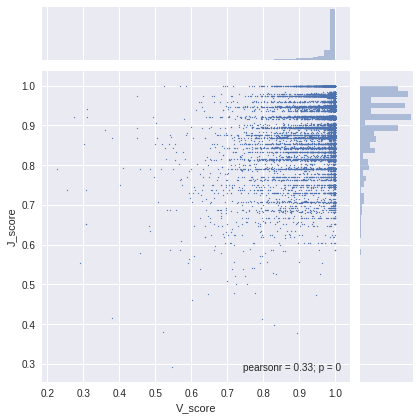

In [25]:
import seaborn as sns
sns.jointplot(x=vjf_annotation['V_score'], y=vjf_annotation['J_score'], s=1)
plt.show()

## 3.2. VJfinder: contigs with a perfect score 

In [26]:
scores = {'V_score == 1' : len(vjf_annotation.loc[vjf_annotation['V_score'] == 1]), 
'J_score == 1' : len(vjf_annotation.loc[vjf_annotation['J_score'] == 1]),
'V_score and J_score == 1' : len(vjf_annotation[(vjf_annotation['V_score']==1) & (vjf_annotation['J_score']==1)])}

In [27]:
print("Contigs with a perfect alignment:\n")

df = pd.DataFrame.from_dict(scores, orient='index')
df.columns = ['# contigs']
df['% contigs'] = df['# contigs'] / len(vjf_annotation) * 100
print(df)

Contigs with a perfect alignment:

                          # contigs  % contigs
J_score == 1                   2206  10.887375
V_score == 1                   3410  16.829533
V_score and J_score == 1        382   1.885303


## 3.3. VJfinder: chain types 

Consider all contigs of specific type from VJF annotation and look what does 10x annotation think about them

In [28]:
def compare_chains(vjf_annotation, filtered_contigs_annotation, chain):
    specific_chain = vjf_annotation.loc[vjf_annotation['Chain_type'] == chain]
    contigs_id = set(specific_chain.index)
    annotation_10x = filtered_contigs_annotation.loc[filtered_contigs_annotation.index.isin(contigs_id)]
    return str(dict(Counter(annotation_10x['chain'])))

In [29]:
chains = {chain : [len(vjf_annotation.loc[vjf_annotation['Chain_type'] == chain]), compare_chains(vjf_annotation, filtered_contigs_annotation, chain)] for chain in ['IGH', 'IGK', 'IGL']}

In [30]:
df = pd.DataFrame.from_dict(chains, orient='index')
df.columns = ['# VJF', '# 10x']
print(df)

     # VJF                       # 10x
IGL   4677  {'Multi': 97, 'IGL': 4580}
IGK   6632  {'Multi': 14, 'IGK': 6618}
IGH   8953  {'Multi': 21, 'IGH': 8932}


## 3.4. VJfinder: V and J hits 

In [56]:
vjf_annotation['V_hit_main'] = vjf_annotation['V_hit'].apply(lambda gene: gene.split('*')[0])
vjf_annotation['J_hit_main'] = vjf_annotation['J_hit'].apply(lambda gene: gene.split('*')[0])
vjf_annotation.head()    

,Chain_type,V_hit,V_start_pos,V_end_pos,V_score,J_hit,J_start_pos,J_end_pos,J_score,V_hit_main,J_hit_main
Read_name,,,,,,,,,,,
AAAGATGTCCGAATGT-1_contig_2,IGH,IGHV3-49*03,1,300,0.993377,IGHJ3*02,325,373,0.980000,IGHV3-49,IGHJ3
AAAGATGTCCGAATGT-1_contig_5,IGK,IGKV1-33*01,1,283,0.986063,IGKJ5*01,285,322,1.000000,IGKV1-33,IGKJ5
AAGCCGCCAGGGTATG-1_contig_1,IGK,IGKV4-1*01,1,293,0.872131,IGKJ2*03,303,340,0.974359,IGKV4-1,IGKJ2
AAGCCGCCAGGGTATG-1_contig_2,IGH,IGHV3-33*06,1,296,0.922297,IGHJ4*02,308,352,0.916667,IGHV3-33,IGHJ4
ACGAGCCCAATGTAAG-1_contig_1,IGK,IGKV1-17*03,1,284,0.989547,IGKJ1*01,286,322,0.973684,IGKV1-17,IGKJ1


In [32]:
def compare_vj_hits(vjf_annotation, filtered_contigs_annotation):
    similar_V = 0
    similar_J = 0
    similar_VJ = 0
    for contig_id in list(vjf_annotation.index):
        is_similar_V = vjf_annotation.loc[contig_id]['V_hit_main'] == filtered_contigs_annotation.loc[contig_id]['v_gene']
        is_similar_J = vjf_annotation.loc[contig_id]['J_hit_main'] == filtered_contigs_annotation.loc[contig_id]['j_gene']
        similar_V += is_similar_V
        similar_J += is_similar_J
        similar_VJ += is_similar_V and is_similar_J
    return {'similar V': similar_V, 'similar J': similar_J, 'similar V and J': similar_VJ}

In [33]:
vj_hits = compare_vj_hits(vjf_annotation, filtered_contigs_annotation)

In [34]:
print('% of similar hits annotations in VJF and 10x\n')
df = pd.DataFrame.from_dict(vj_hits, orient='index')
df.columns = ['# hits']
df['% hits'] = df['# hits'] / len(vjf_annotation) * 100
print(df)

% of similar hits annotations in VJF and 10x

                 # hits     % hits
similar J         19961  98.514461
similar V         16046  79.192577
similar V and J   15829  78.121607


## 3.4. VJfinder: Multi chains

In [35]:
vjf_filtering_info_fname = PATH + '/{}/vjf_result/filtering_info.csv'.format(dataset_name)

In [44]:
vjf_filtering_info = pd.read_csv(vjf_filtering_info_fname, sep='\t', names=['contig_id', 'what', 'smth'], index_col=0)

In [45]:
vjf_filtering_info.head()

,what,smth
contig_id,,
CCAGCGAAGGGTATCG-1_contig_5,VJ_HITS_ARE_EMPTY,NaN
CGATCGGTCCGTAGTA-1_contig_3,VJ_HITS_ARE_EMPTY,NaN
CAAGATCCACACAGAG-1_contig_5,VJ_HITS_ARE_EMPTY,NaN
GGTGCGTGTTCCTCCA-1_contig_1,VJ_HITS_ARE_EMPTY,NaN
TATGCCCAGGTGCACA-1_contig_2,LEFT_UNCOVERED_LIMIT_EXCEEDS,111.0


In [75]:
def multi_filtered_by_vjf(vjf_filtering_info, vjf_annotation):
    multi_id = set(multi_chains.index)
    filtered_10x = vjf_filtering_info.loc[vjf_filtering_info.index.isin(multi_id)]
    annotated_10x = vjf_annotation.loc[vjf_annotation.index.isin(multi_id)]
    return dict(Counter(list(filtered_10x['what']) + list(annotated_10x['Chain_type'])))

In [78]:
multi_vjf = multi_filtered_by_vjf(vjf_filtering_info, vjf_annotation)

In [87]:
print('Multi chaines annotation from VJF\n')
df = pd.DataFrame.from_dict(multi_vjf, orient='index')
df.columns = ['# multi contigs']
df['% multi contigs'] = df['# multi contigs'] / len(multi_chains) * 100
print(df.sort_values(by='# multi contigs',  ascending=False))

Multi chaines annotation from VJF

                              # multi contigs  % multi contigs
VJ_HITS_ARE_EMPTY                        1055        87.697423
IGL                                        97         8.063175
IGH                                        21         1.745636
IGK                                        14         1.163757
LEFT_UNCOVERED_LIMIT_EXCEEDS                6         0.498753
SHORT_V_ALIGNMENT                           4         0.332502
SHORT_J_ALIGNMENT                           4         0.332502
SHORT_ALIGNED_SEGMENT                       2         0.166251


# 4. igBLAST 

## 4.1. igBLAST and BLAST Multi chains

## igBLAST all contigs 

# 5. My annotation

# 6. Final stats